<div style="background-color:#1e1e1e; color:#f0f0f0; padding:12px; border-radius:8px; line-height:1.5; font-size:16px;">

<h2 style="margin-top:0; color:#ffffff;">Options</h2>

The goal of this notebook is to explore several options strategies. To do so, we use both 
<span style="color:#7CFC00;"><b>yahoo finance (yfinance)</b></span> and 
<span style="color:#00CED1;"><b>polygon.io</b></span> data.<br><br>

We lean mostly on the polygon data, which means that each user of this notebook will have to create and store a 
<span style="color:#00CED1;"><b>polygon API key</b></span> somewhere on their local machine.<br><br>

<b style="color:#FF6F61;">Note:</b> The polygon API key that I 
<span style="color:#DA70D6;"><b>(Mike Kovacevich)</b></span> have used to gather the data below corresponds to one of Polygon's paid tiers 
(I think it is $30 a month or something). The goal was to get access to options contracts and be able to analyze them via the "Greeks" and Implied Volatility

</div>


In [1]:
#Install any necessary packages here rather than the command line
!uv pip install dotenv polygon-api-client mplfinance 
!uv pip install --upgrade scipy statsmodels

Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Audited 3 packages in 86ms
Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Resolved 10 packages in 284ms                                        
Audited 10 packages in 1ms


In [34]:
from __future__ import annotations

import os
import requests
from dotenv import load_dotenv
from dataclasses import dataclass
from datetime import date, datetime, timedelta
from datetime import timezone
from dateutil.relativedelta import relativedelta
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import optimize
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from math import exp, log, sqrt
from typing import Iterable, Literal

#Retrieve the API key from another directory that is NOT uploaded to Github
load_dotenv()
API_KEY = os.getenv("POLYGON_API_KEY")

Below we create functions that load options contracts for a given stock ticker (e.g AAPL, AAL, etc). We look at a specific date range of contracts since we want to analyze mediumish term contracts

In [ ]:
def analyze_option_contract(underlying: str, option_ticker: str, api_key: str):
    """Fetch and display Greeks and IV for a specific option contract."""
    url = f"https://api.polygon.io/v3/snapshot/options/{underlying}/{option_ticker}?apiKey={api_key}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"[WARN] Could not fetch option {option_ticker}: {e}")
        return None

    data = response.json()
    results = data.get("results", {})
    if not results:
        print(f"[WARN] No results for option {option_ticker}")
        return None

    return results

def get_current_stock_price(ticker: str) -> float:
    """Fetch current stock price from Polygon."""
    url = f"https://api.polygon.io/v2/last/trade/{ticker}?apiKey={API_KEY}"
    resp = requests.get(url)
    resp.raise_for_status()
    return resp.json()["last"]["price"]

def get_option_contracts(ticker: str, limit: int = 1000, min_days: int = 20, max_days: int = 120):
    """Fetch option contracts for a given ticker within a specified expiration range."""
    base_url = "https://api.polygon.io/v3/reference/options/contracts"
    params = {
        "underlying_ticker": ticker,
        "limit": limit,
        "apiKey": API_KEY
    }

    today = datetime.now(timezone.utc).date()
    min_exp = today + timedelta(days=min_days)
    max_exp = today + timedelta(days=max_days)

    contracts = []
    url = base_url

    while url:
        response = requests.get(url, params=params)
        data = response.json()

        if not data.get("results"):
            break

        for c in data["results"]:
            exp_date = datetime.strptime(c["expiration_date"], "%Y-%m-%d").date()
            if min_exp <= exp_date <= max_exp:
                try:
                    greeks_data = analyze_option_contract(ticker, c["ticker"], API_KEY)
                    if greeks_data:
                        c["greeks"] = greeks_data
                        contracts.append(c)
                except Exception as e:
                    print(f"[WARN] Skipping {c['ticker']} due to error: {e}")
                    continue

        url = data.get("next_url")
        params = {}  # Only needed for the first request

    return contracts

def print_options_contracts(contracts):
    if not contracts:
        print("No option contracts to display.")
        return

    print(f"{'Index':<6} {'Ticker':<25} {'Strike':<10} {'Type':<6} {'Style':<10} {'Expires':<12} {'Exchange'}")
    print("-" * 100)
    for idx, c in enumerate(contracts):
        print(f"{idx:<6} {c['ticker']:<25} {c['strike_price']:<10} {c['contract_type']:<6} {c['exercise_style']:<10} {c['expiration_date']:<12} {c['primary_exchange']}")

def get_latest_closing_price(
    symbol: str,
    from_date: str,
    to_date: str,
    api_key: str,
    multiplier: int = 1,
    timespan: str = "day"
) -> float | None:
    """
    Returns the latest closing price for the given ticker between from_date and to_date.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_date}/{to_date}"
    params = {
        "adjusted": "true",
        "sort": "desc",   # Sort descending so latest is first
        "limit": 1,       # Only need the latest
        "apiKey": api_key
    }

    res = requests.get(url, params=params)
    data = res.json()

    if "results" in data and data["results"]:
        latest = data["results"][0]
        return latest["c"]  # Closing price
    else:
        print("Error or no data:", data)
        return None


In [4]:
#The code below is more script like rather than a notebook - should be cleaned up
ticker = "VOO"
contracts = get_option_contracts(ticker)


Option Details:
Ticker: O:VOO250905C00470000
Delta: 0.9765812599676789
Gamma: 0.0007489846119883646
Theta: -0.12134628858328995
Vega: 0.06538224456084989
Implied Volatility: 0.4872831172547113

Option Details:
Ticker: O:VOO250905C00475000
Delta: 0.9849536591823781
Gamma: 0.0005785919453541188
Theta: -0.08624768181901758
Vega: 0.06519300209368746
Implied Volatility: 0.4213166461264357

Option Details:
Ticker: O:VOO250905C00480000
Delta: 0.9703725610719428
Gamma: 0.0009537329180120907
Theta: -0.13742602624699024
Vega: 0.13223863099740962
Implied Volatility: 0.468675618012667

Option Details:
Ticker: O:VOO250905C00485000
Delta: 0.9736370229962297
Gamma: 0.0009360256788103564
Theta: -0.12267514370151152
Vega: 0.06626798039384539
Implied Volatility: 0.43512402256157845

Option Details:
Ticker: O:VOO250905C00490000
Delta: 0.9715594084901024
Gamma: 0.001033737872921633
Theta: -0.12520308895925047
Vega: 0.1331256915991635
Implied Volatility: 0.41898553032673014

Option Details:
Ticker: O:VOO2

In [5]:
valid_contracts_idx = [
    i for i, contracts in enumerate(contracts)
    if contracts.get('greeks', {}).get('greeks')
]
valid_contracts = [contracts[i] for i in valid_contracts_idx]

In [6]:
valid_contracts[0]

{'cfi': 'OCASPS',
 'contract_type': 'call',
 'exercise_style': 'american',
 'expiration_date': '2025-09-05',
 'primary_exchange': 'BATO',
 'shares_per_contract': 100,
 'strike_price': 470,
 'ticker': 'O:VOO250905C00470000',
 'underlying_ticker': 'VOO',
 'greeks': {'day': {},
  'details': {'contract_type': 'call',
   'exercise_style': 'american',
   'expiration_date': '2025-09-05',
   'shares_per_contract': 100,
   'strike_price': 470,
   'ticker': 'O:VOO250905C00470000'},
  'greeks': {'delta': 0.9765812599676789,
   'gamma': 0.0007489846119883646,
   'theta': -0.12134628858328995,
   'vega': 0.06538224456084989},
  'implied_volatility': 0.4872831172547113,
  'open_interest': 0,
  'underlying_asset': {'ticker': 'VOO'}}}

Lets further look at the actual stock movement of a given ticker symbol

In [7]:
def get_latest_closing_price(
    symbol: str,
    from_date: str,
    to_date: str,
    api_key: str,
    multiplier: int = 1,
    timespan: str = "day"
) -> float | None:
    """
    Returns the latest closing price for the given ticker between from_date and to_date.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_date}/{to_date}"
    params = {
        "adjusted": "true",
        "sort": "desc",   # Sort descending so latest is first
        "limit": 1,       # Only need the latest
        "apiKey": api_key
    }

    res = requests.get(url, params=params)
    data = res.json()

    if "results" in data and data["results"]:
        latest = data["results"][0]
        return latest["c"]  # Closing price
    else:
        print("Error or no data:", data)
        return None

today_date = date.today().strftime("%Y-%m-%d")
previous_date = (date.fromisoformat(today_date) - relativedelta(years=2)).isoformat()

price = get_latest_closing_price(ticker, previous_date, today_date, API_KEY)

In [8]:
price

590.78

In [9]:
multiplier = 1
timespan = "day"

url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{previous_date}/{today_date}"
params = {
    "adjusted": "true",
    "sort": "asc",     # or "desc"
    "limit": 00,
    "apiKey": API_KEY
}

res = requests.get(url, params=params)
data = res.json()

# Preview the results
if "results" in data:
    for candle in data["results"]:
        t = datetime.fromtimestamp(candle["t"] / 1000)
        print(f"{t.date()} - O: {candle['o']} H: {candle['h']} L: {candle['l']} C: {candle['c']} V: {candle['v']}")
else:
    print("Error or no data:", data)

2023-08-14 - O: 408.56 H: 411.74 L: 408.31 C: 411.72 V: 2772912.0
2023-08-15 - O: 410.09 H: 411.7125 L: 406.41 C: 407 V: 4686119.0
2023-08-16 - O: 406.59 H: 408.11 L: 403.87 C: 403.99 V: 3353653.0
2023-08-17 - O: 405.33 H: 405.58 L: 400.37 C: 400.72 V: 7102504.0
2023-08-18 - O: 398.17 H: 402.02 L: 397.85 C: 401.09 V: 4157667.0
2023-08-21 - O: 402.14 H: 404.39 L: 399.99 C: 403.74 V: 3292434.0
2023-08-22 - O: 405.35 H: 405.4 L: 402.06 C: 402.61 V: 2648051.0
2023-08-23 - O: 403.56 H: 407.67 L: 403.47 C: 406.95 V: 3249964.0
2023-08-24 - O: 408.6 H: 409.079 L: 401.4 C: 401.54 V: 3458791.0
2023-08-25 - O: 403.08 H: 405.8 L: 399.71 C: 404.2 V: 4417835.0
2023-08-28 - O: 406.36 H: 407.44 L: 405.1 C: 406.86 V: 3236711.0
2023-08-29 - O: 406.78 H: 412.98 L: 406.57 C: 412.64 V: 3482664.0
2023-08-30 - O: 413.03 H: 415.0292 L: 412.4 C: 414.36 V: 3004516.0
2023-08-31 - O: 414.982 H: 416.12 L: 413.66 C: 413.83 V: 4751131.0
2023-09-01 - O: 416.46 H: 416.88 L: 413.21 C: 414.71 V: 3587971.0
2023-09-05 - O

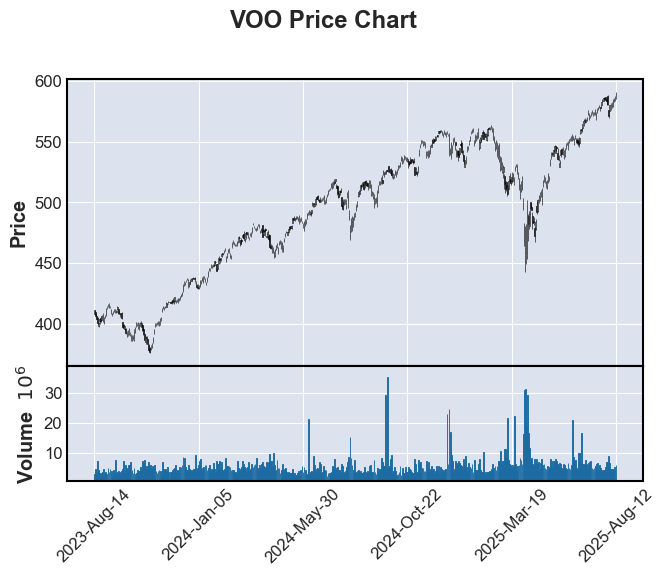

In [12]:
url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{previous_date}/{today_date}"

params = {
    "adjusted": "true",
    "sort": "asc",
    "limit": 600,
    "apiKey": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

if "results" not in data:
    print("Error or no results:", data)
else:
    df = pd.DataFrame(data["results"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")
    df.set_index("t", inplace=True)

    df = df.rename(columns={
        "o": "Open",
        "h": "High",
        "l": "Low",
        "c": "Close",
        "v": "Volume"
    })

    df = df[["Open", "High", "Low", "Close", "Volume"]]

    mpf.plot(df, type="candle", volume=True, title=f"{ticker} Price Chart")


In [15]:
data = pd.DataFrame(data)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
data['results']

0          {'v': 2772912.0, 'vw': 410.319, 'o': 408.56, 'c': 411.72, 'h': 411.74, 'l': 408.31, 't': 1691985600000, 'n': 77649}
1          {'v': 4686119.0, 'vw': 414.2162, 'o': 410.09, 'c': 407, 'h': 411.7125, 'l': 406.41, 't': 1692072000000, 'n': 95304}
2         {'v': 3353653.0, 'vw': 405.9405, 'o': 406.59, 'c': 403.99, 'h': 408.11, 'l': 403.87, 't': 1692158400000, 'n': 97757}
3        {'v': 7102504.0, 'vw': 402.4129, 'o': 405.33, 'c': 400.72, 'h': 405.58, 'l': 400.37, 't': 1692244800000, 'n': 107202}
4        {'v': 4157667.0, 'vw': 399.9369, 'o': 398.17, 'c': 401.09, 'h': 402.02, 'l': 397.85, 't': 1692331200000, 'n': 111613}
                                                                ...                                                           
496      {'v': 4545015.0, 'vw': 580.5482, 'o': 578.25, 'c': 581.64, 'h': 582.27, 'l': 577.41, 't': 1754452800000, 'n': 167339}
497    {'v': 4594260.0, 'vw': 581.2844, 'o': 584.87, 'c': 581.29, 'h': 585.52, 'l': 578.3127, 't': 175453920000

In [16]:
results = pd.json_normalize(data["results"])
flattened_results = pd.concat([data.reset_index(drop=True), results], axis=1)
historical_data = flattened_results[['ticker','vw', 'o', 'h', 'l', 'c', 'v','t','n']]
historical_data['datetime'] = pd.to_datetime(historical_data['t'], unit='ms')
historical_data = historical_data.set_index('datetime')
historical_data.head()

/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_29420/2129047425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_data['datetime'] = pd.to_datetime(historical_data['t'], unit='ms')


,ticker,vw,o,h,l,c,v,t,n
datetime,,,,,,,,,
2023-08-14 04:00:00,VOO,410.3190,408.56,411.7400,408.31,411.72,2772912.0,1691985600000,77649
2023-08-15 04:00:00,VOO,414.2162,410.09,411.7125,406.41,407.00,4686119.0,1692072000000,95304
2023-08-16 04:00:00,VOO,405.9405,406.59,408.1100,403.87,403.99,3353653.0,1692158400000,97757
2023-08-17 04:00:00,VOO,402.4129,405.33,405.5800,400.37,400.72,7102504.0,1692244800000,107202
2023-08-18 04:00:00,VOO,399.9369,398.17,402.0200,397.85,401.09,4157667.0,1692331200000,111613


In [19]:
from __future__ import annotations

def compute_indicators(
    df: pd.DataFrame,
    price_col: str = "vw",
    window_short: int = 10,
    window_long: int = 50,
    ) -> pd.DataFrame:
    """Compute technical indicators often used in professional quantitative trading.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing price data.
    price_col : str, default "vw"
        Column name for the price series.
    window_short : int, default 10
        Short-term window size for moving averages.
    window_long : int, default 50
        Long-term window size for moving averages.

    Returns
    -------
    pd.DataFrame
        Original DataFrame with added indicator columns, including:
        - ret_1: 1-period returns
        - sma_short, sma_long: Simple moving averages
        - ema_short, ema_long: Exponential moving averages
        - momentum: Relative difference between short and long SMA
        - vol_20: Annualized volatility (20-day rolling)
        - rsi: 14-day relative strength index
        - macd, macd_signal: MACD line and signal line
        - zscore_20: 20-day rolling z-score of price
        - skew_20, kurt_20: 20-day rolling skewness and kurtosis
    """
    df = df.copy()
    price = df[price_col]

    # Basic returns and averages
    df["ret_1"] = price.pct_change()
    df["sma_short"] = price.rolling(window_short, min_periods=1).mean()
    df["sma_long"] = price.rolling(window_long, min_periods=1).mean()
    df["ema_short"] = price.ewm(span=window_short, adjust=False).mean()
    df["ema_long"] = price.ewm(span=window_long, adjust=False).mean()

    # Momentum
    df["momentum"] = (df["sma_short"] - df["sma_long"]) / df["sma_long"]

    # Volatility (annualized)
    df["vol_20"] = df["ret_1"].rolling(20, min_periods=1).std() * np.sqrt(252)

    # RSI (14-day)
    delta = price.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14, min_periods=1).mean()
    roll_down = down.rolling(14, min_periods=1).mean()
    rs = roll_up / (roll_down + 1e-12)
    df["rsi"] = 100 - (100 / (1 + rs))

    # MACD (12, 26, 9)
    ema_12 = price.ewm(span=12, adjust=False).mean()
    ema_26 = price.ewm(span=26, adjust=False).mean()
    df["macd"] = ema_12 - ema_26
    df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

    # Z-score of price (20-day)
    rolling_mean = price.rolling(20, min_periods=1).mean()
    rolling_std = price.rolling(20, min_periods=1).std(ddof=0)
    df["zscore_20"] = (price - rolling_mean) / (rolling_std + 1e-12)

    # Higher moments: skewness, kurtosis
    df["skew_20"] = (
        price.rolling(20, min_periods=1).apply(lambda x: pd.Series(x).skew(), raw=False)
    )
    df["kurt_20"] = (
        price.rolling(20, min_periods=1).apply(lambda x: pd.Series(x).kurt(), raw=False)
    )

    return df.dropna()


def plot_indicators(indicators_df: pd.DataFrame) -> None:
    """Plot key technical indicators from the computed indicators DataFrame.

    Parameters
    ----------
    indicators_df : pd.DataFrame
        DataFrame with DateTimeIndex containing price and technical indicators.
    """
    fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    plot_configs = [
        {
            "title": "Price & Moving Averages",
            "plots": [
                ("vw", "VWAP", "black", "-"),
                ("sma_short", "SMA Short", "blue", "-"),
                ("sma_long", "SMA Long", "red", "-"),
                ("ema_short", "EMA Short", "cyan", "--"),
                ("ema_long", "EMA Long", "magenta", "--"),
            ],
            "hline": None,
        },
        {
            "title": "Momentum",
            "plots": [("momentum", "Momentum", "green", "-")],
            "hline": 0,
        },
        {
            "title": "MACD",
            "plots": [
                ("macd", "MACD", "purple", "-"),
                ("macd_signal", "Signal", "orange", "-"),
            ],
            "hline": 0,
        },
    ]

    # Loop through first 3 subplots
    for ax, config in zip(axs[:3], plot_configs):
        for col, label, color, style in config["plots"]:
            ax.plot(indicators_df.index, indicators_df[col], label=label, color=color, linestyle=style)
        if config["hline"] is not None:
            ax.axhline(config["hline"], color="gray", linestyle="--")
        ax.set_title(config["title"])
        ax.legend()
        ax.grid(True)

    # Volatility + RSI panel
    axs[3].plot(indicators_df.index, indicators_df["vol_20"], label="Volatility (20d)", color="brown")
    ax2 = axs[3].twinx()
    ax2.plot(indicators_df.index, indicators_df["rsi"], label="RSI (14)", color="blue")
    ax2.set_ylim(0, 110)
    axs[3].set_title("Volatility & RSI")
    axs[3].grid(True)

    # Combine legends for last subplot
    lines, labels = axs[3].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axs[3].legend(lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.1, 0.5))

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


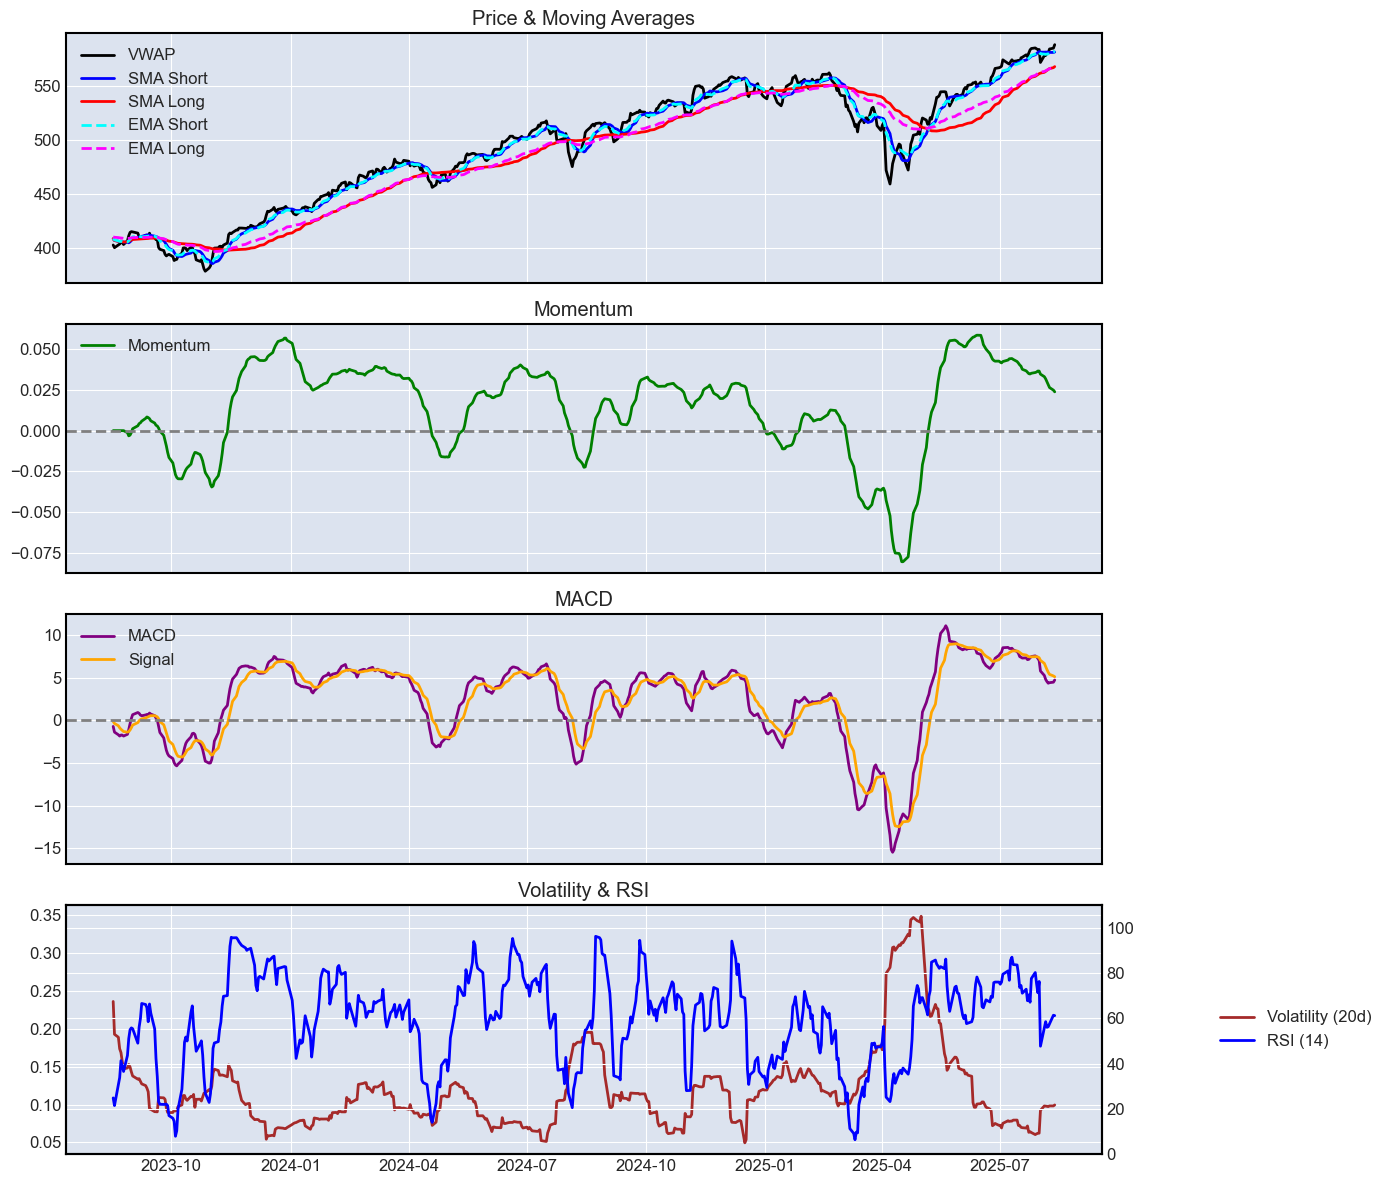

In [20]:
indicators = compute_indicators(historical_data, price_col='vw')
plot_indicators(indicators)

In [27]:
def american_option_price(
    s: float,
    k: float,
    r: float,
    q: float,
    sigma: float,
    t: float,
    opt_type: Literal["call", "put"],
    steps: int = 100,
) -> float:
    """Price an American option using a Cox–Ross–Rubinstein binomial tree."""
    if sigma <= 0 or t <= 0 or s <= 0 or k <= 0:
        return max(0.0, (s - k) if opt_type == "call" else (k - s))

    dt = t / steps
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    disc = exp(-r * dt)
    p = (exp((r - q) * dt) - d) / (u - d)

    # Terminal values
    prices = np.array([s * (u**j) * (d ** (steps - j)) for j in range(steps + 1)])
    if opt_type == "call":
        values = np.maximum(prices - k, 0.0)
    else:
        values = np.maximum(k - prices, 0.0)

    # Backward induction with early exercise
    for i in range(steps - 1, -1, -1):
        prices = prices[: i + 1] * u ** -0.5 * d ** 0.5  # adjust stepwise prices
        values = disc * (p * values[1 : i + 2] + (1 - p) * values[: i + 1])
        if opt_type == "call":
            values = np.maximum(values, prices - k)
        else:
            values = np.maximum(values, k - prices)
    return values[0]

@dataclass(frozen=True)
class OptionRow:
    ticker: str
    underlying: str
    contract_type: Literal["call", "put"]
    exchange: str
    expiry: pd.Timestamp
    strike: float
    shares_per_contract: int
    delta: float
    gamma: float
    theta: float
    vega: float
    iv: float
    open_interest: int

In [30]:
def contracts_to_frame(contracts: Iterable[dict]) -> pd.DataFrame:
    rows: list[OptionRow] = []
    for c in contracts:
        g = c.get("greeks", {})
        details = g.get("details", {})
        greeks = g.get("greeks", {})
        rows.append(
            OptionRow(
                ticker=c.get("ticker"),
                underlying=c.get("underlying_ticker"),
                contract_type=c.get("contract_type"),
                exchange=c.get("primary_exchange", ""),
                expiry=pd.to_datetime(c.get("expiration_date")),
                strike=float(c.get("strike_price")),
                shares_per_contract=int(c.get("shares_per_contract", 100)),
                delta=float(greeks.get("delta", np.nan)),
                gamma=float(greeks.get("gamma", np.nan)),
                theta=float(greeks.get("theta", np.nan)),
                vega=float(greeks.get("vega", np.nan)),
                iv=float(g.get("implied_volatility", np.nan)),
                open_interest=int(g.get("open_interest", 0)),
            )
        )
    df = pd.DataFrame([r.__dict__ for r in rows])
    now = pd.Timestamp.utcnow().tz_localize(None)
    df["expiry"] = pd.to_datetime(df["expiry"]).dt.tz_localize(None)
    df["days_to_expiry"] = (df["expiry"] - now).dt.days.clip(lower=0)
    df["days_to_expiry"] = (df["expiry"] - now).dt.days.clip(lower=0)
    return df

def assess_options(
    contracts: Iterable[dict],
    indicators: pd.DataFrame,
    *,
    risk_free: float = 0.04,
    dividend_yield: float = 0.015,
    delta_band: tuple[float, float] = (0.25, 0.35),
    min_open_interest: int = 10,
    min_days: int = 7,
    max_days: int = 90,
    side: Literal["buy", "sell"] = "buy",
) -> pd.DataFrame:
    if indicators.empty:
        raise ValueError("indicators is empty")

    spot = float(indicators["vw"].iloc[-1])
    rv20 = float(indicators["vol_20"].iloc[-1])
    momentum = float(indicators.get("momentum", pd.Series([0.0])).iloc[-1])

    opt = contracts_to_frame(contracts)
    lo, hi = delta_band
    opt = opt.loc[
        (opt["open_interest"] >= min_open_interest)
        & (opt["days_to_expiry"].between(min_days, max_days))
        & (opt["delta"].abs().between(lo, hi))
    ].copy()
    if opt.empty:
        return opt

    opt["s"] = spot
    opt["rv20"] = rv20
    opt["ttm_yrs"] = opt["days_to_expiry"] / 365.0
    opt["moneyness"] = np.log(spot / opt["strike"].astype(float))

    theo_prices = []
    for row in opt.itertuples(index=False):
        sigma = max(1e-6, rv20)
        t = max(1e-6, row.ttm_yrs)
        p = american_option_price(
            s=spot,
            k=float(row.strike),
            r=risk_free,
            q=dividend_yield,
            sigma=sigma,
            t=t,
            opt_type=row.contract_type,
        )
        theo_prices.append(p * row.shares_per_contract)
    opt["theo_rv"] = theo_prices

    call_mask = opt["contract_type"].eq("call")
    put_mask = ~call_mask
    opt.loc[call_mask, "breakeven"] = opt.loc[call_mask, "strike"] + (
        opt.loc[call_mask, "theo_rv"] / opt.loc[call_mask, "shares_per_contract"]
    )
    opt.loc[put_mask, "breakeven"] = opt.loc[put_mask, "strike"] - (
        opt.loc[put_mask, "theo_rv"] / opt.loc[put_mask, "shares_per_contract"]
    )

    opt["vol_edge"] = opt["iv"] - rv20
    opt["gamma_theta"] = opt["gamma"].abs() / (opt["theta"].abs() + 1e-12)

    def _z(x: pd.Series) -> pd.Series:
        mu, sd = x.mean(), x.std(ddof=0)
        return (x - mu) / (sd + 1e-12)

    features = pd.DataFrame(
        {
            "edge": -opt["vol_edge"],
            "convexity": _z(opt["gamma_theta"]),
            "delta_target": -_z((opt["delta"].abs() - np.mean(delta_band)).abs()),
            "liquidity": _z(np.log1p(opt["open_interest"])),
            "momentum": np.sign(momentum) * np.where(call_mask, 1.0, -1.0),
            "moneyness": _z(opt["moneyness"]),
        }
    )

    weights_buy = {
        "edge": 0.35,
        "convexity": 0.2,
        "delta_target": 0.1,
        "liquidity": 0.15,
        "momentum": 0.15,
        "moneyness": 0.05,
    }
    weights_sell = {
        "edge": -0.4,
        "convexity": -0.2,
        "delta_target": 0.05,
        "liquidity": 0.2,
        "momentum": -0.1,
        "moneyness": 0.05,
    }
    w = weights_buy if side == "buy" else weights_sell
    opt["score"] = sum(features[k] * v for k, v in w.items())

    cols = [
        "ticker",
        "underlying",
        "contract_type",
        "expiry",
        "days_to_expiry",
        "strike",
        "delta",
        "gamma",
        "theta",
        "vega",
        "iv",
        "rv20",
        "vol_edge",
        "gamma_theta",
        "breakeven",
        "open_interest",
        "score",
    ]
    return opt.sort_values("score", ascending=False)[cols]

def suggest_options(
    contracts: Iterable[dict],
    indicators: pd.DataFrame,
    *,
    top_n: int = 10,
    side: Literal["buy", "sell"] = "buy",
    **kwargs,
) -> pd.DataFrame:
    ranked = assess_options(contracts, indicators, side=side, **kwargs)
    return ranked.head(top_n)

In [33]:
ranked = assess_options(contracts, indicators, side="buy")
top5 = suggest_options(contracts, indicators, top_n=5, side="buy")
top5

,ticker,underlying,contract_type,expiry,days_to_expiry,strike,delta,gamma,theta,vega,iv,rv20,vol_edge,gamma_theta,breakeven,open_interest,score
239,O:VOO250919C00605000,VOO,call,2025-09-19,35,605.0,0.313515,0.017331,-0.115098,0.692620,0.109169,0.09952,0.009649,0.150574,607.163774,189,0.421334
477,O:VOO251017C00610000,VOO,call,2025-10-17,63,610.0,0.314337,0.013071,-0.090959,0.936722,0.109463,0.09952,0.009943,0.143708,613.193274,85,0.221393
143,O:VOO250912C00605000,VOO,call,2025-09-12,28,605.0,0.274350,0.019216,-0.113390,0.628000,0.103771,0.09952,0.004251,0.169464,606.557832,11,0.164211
277,O:VOO250919P00585000,VOO,put,2025-09-19,35,585.0,-0.342121,0.016003,-0.104349,0.719537,0.126265,0.09952,0.026744,0.153363,317.801826,404,0.080750
142,O:VOO250912C00602500,VOO,call,2025-09-12,28,602.5,0.330645,0.020049,-0.127327,0.617384,0.107125,0.09952,0.007605,0.157460,604.554675,15,0.041783


In [ ]:
def prepare_options_df(contracts, indicators_df):
    """Convert contracts list into DataFrame, merge with computed indicators, compute IV-RV diff and score."""
    rows = []
    for c in contracts:
        greeks = c.get("greeks", {}).get("greeks", {})
        rows.append({
            "underlying_ticker": c.get("underlying_ticker") or c.get("underlying", {}).get("ticker"),
            "strike_price": c.get("strike_price"),
            "expiration_date": c.get("expiration_date"),
            "implied_volatility": c.get("greeks", {}).get("implied_volatility"),
            "delta": greeks.get("delta"),
            "shares_per_contract": c.get("shares_per_contract", 100)
        })
    df = pd.DataFrame(rows)

    df["expiry"] = pd.to_datetime(df["expiration_date"], errors="coerce").dt.tz_localize(None)

    if "vol_20" not in indicators_df.columns:
        raise ValueError("indicators_df must contain 'vol_20' column from compute_indicators")

    rv_map = indicators_df.groupby("ticker")["vol_20"].last().to_dict()
    df["realized_vol"] = df["underlying_ticker"].map(rv_map)

    df = df.dropna(subset=["implied_volatility", "realized_vol", "delta"])

    df["iv_rv_diff"] = df["implied_volatility"] - df["realized_vol"]
    df["score"] = df["iv_rv_diff"] * np.abs(df["delta"])
    return df

def plot_iv_rv_heatmap(options_df):
    """Plot a heatmap of IV-RV difference by strike and expiry with better aesthetics and labeled colorbar."""
    pivot = options_df.pivot_table(index="strike_price", columns="expiry", values="iv_rv_diff")
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(pivot, cmap="coolwarm", center=0, annot=False, cbar_kws={'label': 'IV - RV Difference'})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    plt.title("IV - RV Difference by Strike and Expiry", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Expiry", fontsize=14)
    plt.ylabel("Strike Price", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_score_heatmap(options_df):
    """Plot a heatmap of option scores by strike and expiry."""
    if not {"strike_price", "expiry", "score"}.issubset(options_df.columns):
        raise ValueError("options_df must contain strike_price, expiry, and score columns")
    pivot = options_df.pivot_table(index="strike_price", columns="expiry", values="score")
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(pivot, cmap="viridis", annot=False, cbar_kws={'label': 'Option Score'})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    plt.title("Option Score by Strike and Expiry", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Expiry", fontsize=14)
    plt.ylabel("Strike Price", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def backtest_buy_ranked_calls(options_df, underlying_df, top_n=5):
    """Simple backtest: Buy top N ranked calls and hold until expiry."""
    results = []
    for expiry, group in options_df.groupby("expiry"):
        top_calls = group.nlargest(top_n, "score")
        for _, call in top_calls.iterrows():
            entry_price = underlying_df.loc[underlying_df.index[0], "vw"]
            exit_price = underlying_df.loc[underlying_df.index[-1], "vw"]
            pnl = (exit_price - entry_price) * call["delta"] * call["shares_per_contract"]
            results.append({
                "expiry": expiry,
                "strike": call["strike_price"],
                "pnl": pnl,
                "score": call["score"]
            })
    return pd.DataFrame(results)

def analyze_performance(pnl_series):
    import empyrical as ep
    returns = pnl_series.pct_change().dropna()
    stats = {
        "cagr": ep.annual_return(returns),
        "sharpe": ep.sharpe_ratio(returns),
        "max_drawdown": ep.max_drawdown(returns)
    }
    return stats

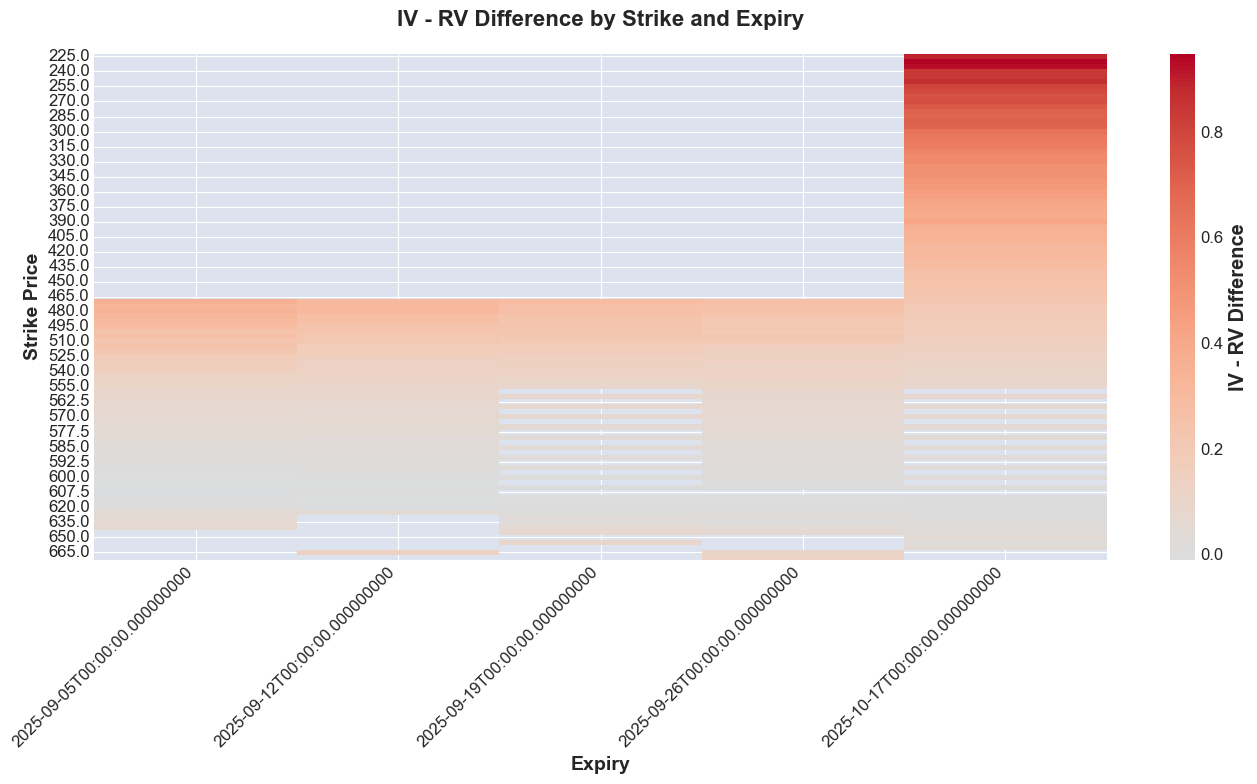

In [46]:
options = prepare_options_df(contracts, indicators)
plot_iv_rv_heatmap(options)

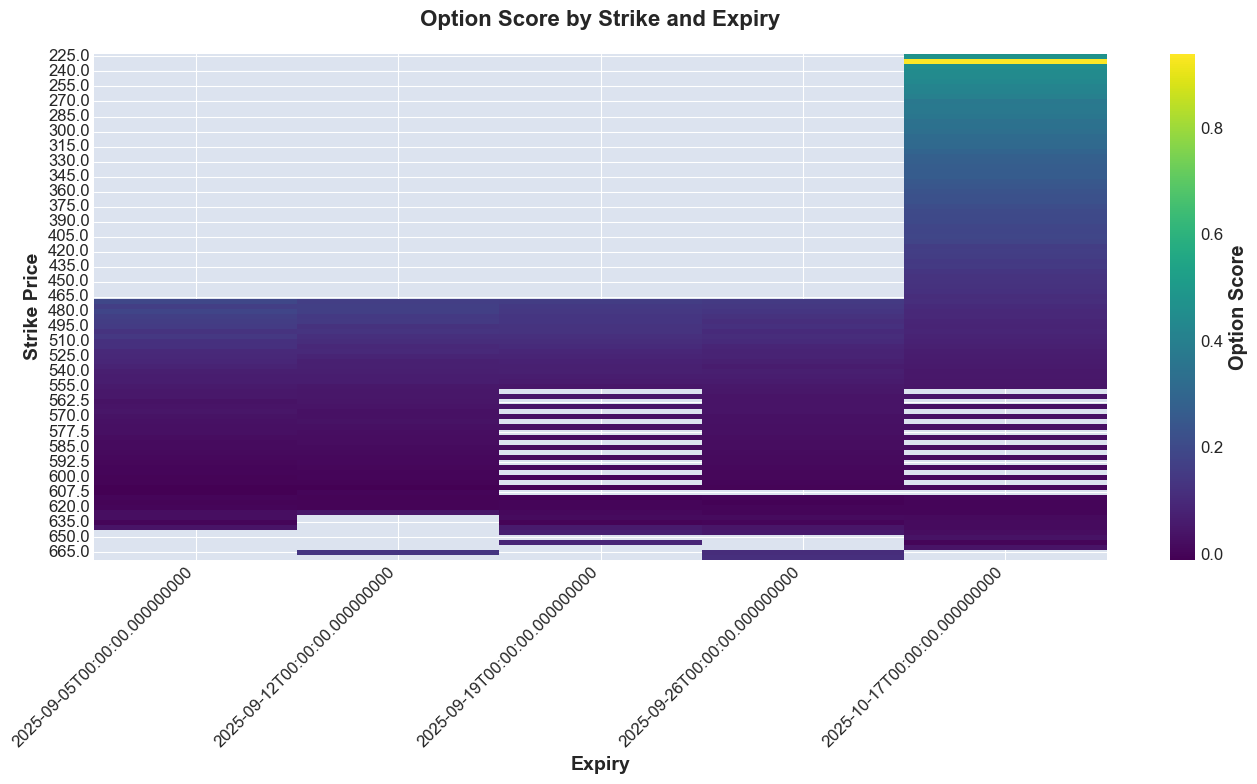

In [47]:
plot_score_heatmap(options)